In [44]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.losses import MeanSquaredError


# Carga y Preparación de data

In [2]:
consumo = pd.read_excel("CONSUMO-2024-06.xlsx", skiprows = 6)
importacion = pd.read_excel("IMPORTACION-VOLUMEN-2024-06.xlsx", skiprows = 6)
precios2024 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2024", skiprows = 9, header = None, 
                        names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2023 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2023", skiprows = 9, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2022 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2022", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2021 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2021", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])

In [3]:
precios2024.drop(precios2024.tail(9).index, inplace = True)
precios2023.drop(precios2023.tail(2).index, inplace = True)
precios2022.drop(precios2022.tail(2).index, inplace = True)
precios2021.drop(precios2021.tail(2).index, inplace = True)

In [4]:
precios = pd.concat([precios2021, precios2022, precios2023, precios2024], ignore_index = True)

In [5]:
#Se suman los consumos de Diesel, ya que de 2000 a 2018 se consumía alto en azufre y a partir de enero 2018 se consumía bajo en azufre
consumo["Diesel"] = consumo["Diesel bajo azufre"]+consumo["Diesel alto azufre"]
importacion["Diesel"] = importacion["Diesel bajo azufre"]+importacion["Diesel alto azufre"]

In [6]:
consumo = consumo[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
importacion = importacion[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
precios = precios[["Fecha", "Diesel", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", "Regular", "Superior"]].copy()

In [7]:
consumo.drop(consumo.tail(3).index, inplace = True)
importacion.drop(importacion.tail(3).index, inplace = True)

In [8]:
consumo["Fecha"] = pd.to_datetime(consumo["Fecha"])
importacion["Fecha"] = pd.to_datetime(importacion["Fecha"])
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

# Modelos LSTM

In [9]:
tf.random.set_seed(1122)

## Consumo Gasolina Regular

In [10]:
regular = consumo[["Fecha", "Gasolina regular"]].copy()
regular.set_index("Fecha", inplace = True)
regular.head()


,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34


In [11]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
regularTest = adfuller(regular, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba          2.430669
p-value                        0.999024
# de retardos usados          14.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [12]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
regular_diff = regular.diff()
regular_diff.fillna(0,inplace = True)
regularTest = adfuller(regular_diff, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba         -4.316925
p-value                        0.000415
# de retardos usados          16.000000
# de observaciones usadas    277.000000
Critical Value (1%)           -3.454180
Critical Value (5%)           -2.872031
Critical Value (10%)          -2.572360
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

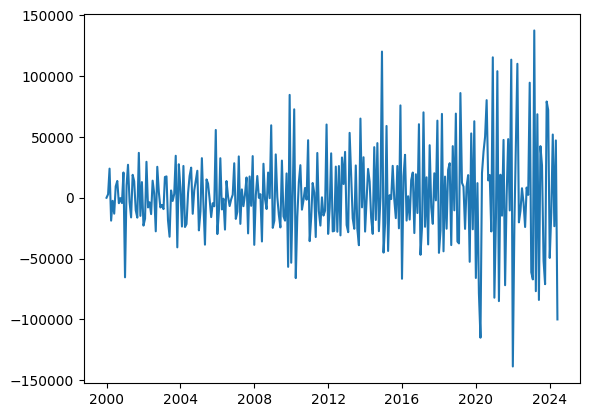

In [13]:
plt.plot(regular_diff)

In [15]:
scaler = StandardScaler()
regular_diff_scaled = scaler.fit_transform(regular_diff)

Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [69]:
num_separacion = consumo.index[consumo["Fecha"]==pd.to_datetime("2021-12")][0]
train = regular_diff_scaled[:num_separacion]
test = regular_diff_scaled[num_separacion:]
#train = regular_diff[:num_separacion]
#test = regular_diff[num_separacion:]

In [71]:
def df_a_X_y(df,retrasos = 1):
    if type(df) is pd.DataFrame:
        df_as_np = df.to_numpy()
    else:
        df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-retrasos):
        row = [a for a in df_as_np[i:(i+retrasos)]]
        X.append(row)
        label = df_as_np[i+retrasos][0]
        y.append(label)
        
    return np.array(X), np.array(y)
retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)

x_test,y_test = df_a_X_y(test, retrasos)

## Creación del modelo

In [73]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [75]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7002
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6683 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6523 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6375 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6229 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6089 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5965 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5858  
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5772 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5707 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5660  
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5628  
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5606 
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5591  
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5582  
Epoch 16/50
9/9 ━━━━━━━━━━━━━━

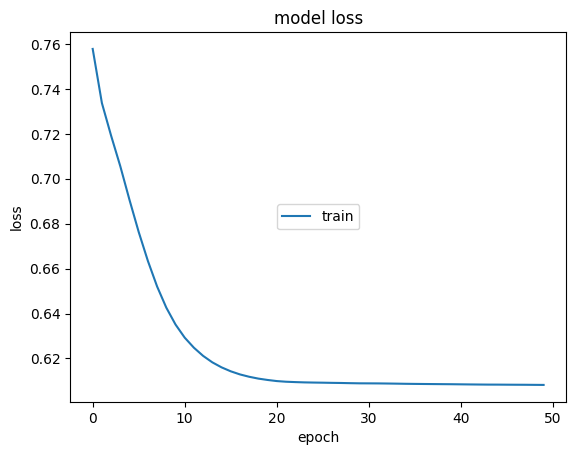

In [76]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='center')

In [77]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4121  
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.2310


2.2310285568237305

In [78]:
train_preds = modelo1.predict(x_train).flatten()
resultDF = pd.DataFrame({'Predicted': train_preds, 'Actual': y_train})

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [79]:
resultDF

,Predicted,Actual
0,0.143173,0.022439
1,0.097589,0.564369
2,-0.249915,-0.535481
3,0.334598,-0.116413
4,0.182474,-0.387844
...,...,...
257,0.323031,1.171666
258,-0.656805,-1.901753
259,0.455258,0.004742
260,0.108513,1.188711


## Importación Diesel

In [ ]:
diesel = importacion[['Fecha', 'Diesel']].copy()
diesel.set_index('Fecha', inplace = True)

train_size = int(len(diesel) * 0.8)
train_diesel = diesel[0:train_size]
test_diesel = diesel[train_size:len(diesel)]

ts_diesel = train_diesel['Diesel']